Statement of Purpose:
The collection of community health needs and outcomes data allows for health systems to assess the current issues facing their community. But I believe that the volume of data collected at the county level is sufficient to actually predict future health outcomes. This predictive power can be used to preempt adverse health outcomes before they create a burden on local health systems.

Source Data:
First, I’ll compile a master dataset including relevant demographic data, 34 Social Determinants of Health (SDOHs) and 3 specific health outcomes to predict for all US counties for the years 2018-2020. The two major sources I’ll use are County Health Rankings and cms.gov Mapping Medicare Discrepancies datasets. 

Analysis:
I’ll treat the demographic data and 34 SDOHs as features, and 3 outcomes (number of hospitalizations, depression & diabetes prevlance) as the targets. The model I’ll use is a multi-output random forest regressor. The Random Forest algorithm can handle the large variety and divergent scales of data found among the 34 SDOHs. And as a multi-output model, it can generate predictions for all 3 health outcomes. After training the model on the 2013-2017 data, I can verify it using 2019 as test data. Descoping might be necessary as I assess the features. 

This model will be able to describe which determinants are most closely correlated with particular health outcomes over time. I will use this information to identify a county at high risk for one of the selected health outcomes.

In [1]:
#import libraries for reading data and EDA
import numpy as np
import pandas as pd
import glob
import warnings

warnings.filterwarnings("ignore")

First I'll load and format data from the Mapping Medicare Disparities tool (https://data.cms.gov/mapping-medicare-disparities). All of the data is at the county level for years 2012 - 2017:<br>
1) Total number of hospitalizations for depression-related conditions<br>
2) Total number of hospitalizations for other causes<br>
3) Prevalence of depression<br>
4) Number of hospitalizations for opioid use disorders <br>
Then I'll extract the 5 columns needed to merge with other datasets (state, county, fips, year, and indicator)


In [2]:
# read 24 Mapping Medicare Discrepancies files, create and name 24 dfs

# Read in data on number of hospitalizations for depression
mmd_dhosp_files = glob.glob('mmd_dhosp*.csv')
for i, file in enumerate(mmd_dhosp_files):
    if i == 0:
        df = pd.read_csv(file)
        df = df[df.condition=='Depressive Disorders'][['state', 'county', 'fips', 'year', 'analysis_value']]
        df.columns = ['state', 'county', 'fips', 'year', 'Dhosp']
    else:
        temp = pd.read_csv(file)
        temp = temp[temp.condition=='Depressive Disorders'][['state', 'county', 'fips', 'year', 'analysis_value']]
        temp.columns = ['state', 'county', 'fips', 'year', 'Dhosp']
        df = pd.concat([df, temp])

# Read in data on number of hospitalizations for all causes
mmd_all_prim_files = glob.glob('mmd_all_prim*.csv')
for i, file in enumerate(mmd_all_prim_files):
    if i == 0:
        df2 = pd.read_csv(file)
        df2 = df2[df2.condition=='All-Cause Hospitalizations'][['state', 'county', 'fips', 'year', 'analysis_value']]
        df2.columns = ['state', 'county', 'fips', 'year', 'All_prim']
    else:
        temp = pd.read_csv(file)
        temp = temp[temp.condition=='All-Cause Hospitalizations'][['state', 'county', 'fips', 'year', 'analysis_value']]
        temp.columns = ['state', 'county', 'fips', 'year', 'All_prim']
        df2 = pd.concat([df2, temp])
df = pd.merge(df, df2, on=['state', 'county', 'fips', 'year'])
    
# Read in data on prevalence of depression
mmd_dprev_files = glob.glob('mmd_dprev*.csv')
for i, file in enumerate(mmd_dprev_files):
    if i == 0:
        df3 = pd.read_csv(file)
        df3 = df3[df3.condition=='Depression'][['state', 'county', 'fips', 'year', 'analysis_value']]
        df3.columns = ['state', 'county', 'fips', 'year', 'Dprev']
    else:
        temp = pd.read_csv(file)
        temp = temp[temp.condition=='Depression'][['state', 'county', 'fips', 'year', 'analysis_value']]
        temp.columns = ['state', 'county', 'fips', 'year', 'Dprev']
        df3 = pd.concat([df3, temp])
df = pd.merge(df, df3, on=['state', 'county', 'fips', 'year'])
    
# Read in data on number of hospitalizations for opioid use
mmd_opd_files = glob.glob('mmd_opd*.csv')
for i, file in enumerate(mmd_opd_files):
    if i == 0:
        df4 = pd.read_csv(file)
        df4 = df4[df4.condition=='Overarching Opioid Use Disorder (OUD) Indicator'][['state', 'county', 'fips', 'year', 'analysis_value']]
        df4.columns = ['state', 'county', 'fips', 'year', 'OUD']
    else:
        temp = pd.read_csv(file)
        temp = temp[temp.condition=='Overarching Opioid Use Disorder (OUD) Indicator'][['state', 'county', 'fips', 'year', 'analysis_value']]
        temp.columns = ['state', 'county', 'fips', 'year', 'OUD']
        df4 = pd.concat([df4, temp])
mmd_df = pd.merge(df, df4, on=['state', 'county', 'fips', 'year'])

mmd_df.head()

,state,county,fips,year,Dhosp,All_prim,Dprev,OUD
0,ALABAMA,Autauga County,1001,2013,1,302,13,8
1,ALABAMA,Baldwin County,1003,2013,1,273,13,8
2,ALABAMA,Barbour County,1005,2013,3,310,12,5
3,ALABAMA,Bibb County,1007,2013,3,303,16,16
4,ALABAMA,Blount County,1009,2013,3,281,17,13


The second data source I'll use is County Health Rankings (CHR, https://www.countyhealthrankings.org/). CHR provides county-level data related to demographics and Social Determinants of Health (SDOHs). This includes data economic information such as medium income and unemployment, environmental data such as air pollution, and educational data such as absenteeism and level of education.

In [3]:
# read and format County Health Rankings data
chr_2012 = pd.read_csv('chr_data2012.csv')
chr_2013 = pd.read_csv('chr_data2013.csv')
chr_2014 = pd.read_csv('chr_data2014.csv')
chr_2015 = pd.read_csv('chr_data2015.csv')
chr_2016 = pd.read_csv('chr_data2016.csv')
chr_2017 = pd.read_csv('chr_data2017.csv')
chr_2018 = pd.read_csv('chr_data2018.csv')
chr_2019 = pd.read_csv('chr_data2019.csv')

def format_df(df):
    df = df.drop([0, 1])
    for i, col in enumerate(df.columns):
        if i < 7: pass
        elif col[-5:] != 'value':
            df = df.drop(columns = col)
    df = df.drop(columns = ['State FIPS Code', 'County FIPS Code', 'County Ranked (Yes=1/No=0)'])
    df = df.rename(columns={"5-digit FIPS Code": "fips", "Name": "county", "Release Year": "year"})
    return(df)

chr_2012 = format_df(chr_2012)
chr_2013 = format_df(chr_2013)
chr_2014 = format_df(chr_2014)
chr_2015 = format_df(chr_2015)
chr_2016 = format_df(chr_2016)
chr_2017 = format_df(chr_2017)
chr_2018 = format_df(chr_2018)
chr_2019 = format_df(chr_2019)

In [4]:
# concatenate datasets into 2013 - 2017 df
chr_df = pd.concat([chr_2013, chr_2014, chr_2015, chr_2016, chr_2017], sort=True)
print(chr_df.shape)
chr_df.head()

(15956, 125)


,% 65 and older raw value,% American Indian and Alaskan Native raw value,% Asian raw value,% Females raw value,% Hispanic raw value,% Native Hawaiian/Other Pacific Islander raw value,% Non-Hispanic African American raw value,% Non-Hispanic white raw value,% Rural raw value,% below 18 years of age raw value,...,Unemployment raw value,Uninsured adults raw value,Uninsured children raw value,Uninsured raw value,Violent crime raw value,W-2 enrollment raw value,Year structure built raw value,county,fips,year
2,0.1400421426,0.0069331257,0.0119004985,0.5149662484,0.0403661243,0.0010883371,0.2618865481,0.6676482591,0.409631829,0.2346874909,...,0.09,0.212,0.063,0.169,426.569135,NaN,NaN,Alabama,01000,2013
3,0.1225505274,0.0048310927,0.0092460238,0.5122043896,0.0260191434,0.000940887,0.1832558308,0.7640183111,0.4200216232,0.2603361862,...,0.08,0.174,0.053,0.136,300.33668316,NaN,NaN,Autauga County,01001,2013
4,0.1707236085,0.0071927034,0.0075568909,0.5115174301,0.0452931442,0.0006587509,0.0957491819,0.8324630323,0.4227909911,0.2279867393,...,0.081,0.231,0.091,0.191,214.73520962,NaN,NaN,Baldwin County,01003,2013
5,0.1462443305,0.0064899148,0.0044618164,0.4654301412,0.0534680482,0.0016962277,0.4640657841,0.4667944983,0.677896347,0.2181127623,...,0.114,0.236,0.064,0.185,150.04942805,NaN,NaN,Barbour County,01005,2013
6,0.1326100325,0.0031186858,0.0012738294,0.4613897918,0.0198980936,0.0013177545,0.2221734165,0.7452341211,0.6835260746,0.2205042607,...,0.099,0.224,0.061,0.177,246.49755063,NaN,NaN,Bibb County,01007,2013


I'll merge data from the two sources (MMD and CHR) on the value 'fips' (Federal Information Processing Standard), which is a unique 5-digit indicator given to each county in the country. But first I'll add a leading '0' to the MMD dataframe and convert the 'years' value in the CHR data to int.

In [5]:
pred_df = pd.concat([chr_2018, chr_2019], sort=True)

In [6]:
def add_leading_zero(val):
    if len(str(val)) == 4:
        val = '0' + str(val)
    return(val)

mmd_df.fips = mmd_df.fips.apply(lambda x: add_leading_zero(x))
mmd_df.state = df.state.apply(lambda x: x.capitalize())

chr_df.dropna(subset=['year'], inplace=True)
chr_df['year'] = chr_df['year'].astype('int')

print(chr_df.shape)
print(mmd_df.shape)

master_df = pd.merge(mmd_df, chr_df, on=['fips', 'year'], how='inner')
print(master_df.shape)
master_df

(15955, 125)
(19364, 8)
(7151, 131)


,state,county_x,fips,year,Dhosp,All_prim,Dprev,OUD,% 65 and older raw value,% American Indian and Alaskan Native raw value,...,Total female population raw value,Total male population raw value,Unemployment raw value,Uninsured adults raw value,Uninsured children raw value,Uninsured raw value,Violent crime raw value,W-2 enrollment raw value,Year structure built raw value,county_y
0,Alabama,Autauga County,01001,2013,1,302,13,8,0.1225505274,0.0048310927,...,NaN,NaN,0.08,0.174,0.053,0.136,300.33668316,NaN,NaN,Autauga County
1,Alabama,Baldwin County,01003,2013,1,273,13,8,0.1707236085,0.0071927034,...,NaN,NaN,0.081,0.231,0.091,0.191,214.73520962,NaN,NaN,Baldwin County
2,Alabama,Barbour County,01005,2013,3,310,12,5,0.1462443305,0.0064899148,...,NaN,NaN,0.114,0.236,0.064,0.185,150.04942805,NaN,NaN,Barbour County
3,Alabama,Bibb County,01007,2013,3,303,16,16,0.1326100325,0.0031186858,...,NaN,NaN,0.099,0.224,0.061,0.177,246.49755063,NaN,NaN,Bibb County
4,Alabama,Blount County,01009,2013,3,281,17,13,0.1503372228,0.0062243182,...,NaN,NaN,0.083,0.239,0.081,0.193,101.84881493,NaN,NaN,Blount County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7146,Wyoming,Sweetwater County,56037,2017,0,210,14,17,0.100255,0.0129073,...,NaN,NaN,0.0460107,0.174065,0.0637447,0.140341,350.161,NaN,NaN,Sweetwater County
7147,Wyoming,Teton County,56039,2017,0,173,14,6,0.129773,0.0107243,...,NaN,NaN,0.0377767,0.166082,0.0970266,0.150427,NaN,NaN,NaN,Teton County
7148,Wyoming,Uinta County,56041,2017,0,212,14,19,0.1168,0.0126789,...,NaN,NaN,0.0487429,0.167006,0.0601751,0.130855,40.3594,NaN,NaN,Uinta County
7149,Wyoming,Washakie County,56043,2017,0,262,14,26,0.20329,0.0172911,...,NaN,NaN,0.0402591,0.204609,0.0839618,0.168754,78.5053,NaN,NaN,Washakie County


In [7]:
# make the the column names more readable by dropping "raw value" from the name
for col in master_df:
    if col[-5:] == 'value':
        master_df = master_df.rename(columns={col: col[:-10]})

# find and count sparse columns
percent_missing = master_df.isnull().sum() * 100 / len(chr_df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})        

keep_columns = missing_value_df[missing_value_df.percent_missing <= 10].index

print(len(missing_value_df[percent_missing > 5]))
missing_value_df

78


,percent_missing
state,0.000000
county_x,0.000000
fips,0.000000
year,0.000000
Dhosp,0.000000
...,...
Uninsured,0.000000
Violent crime,1.309934
W-2 enrollment,42.575995
Year structure built,42.563460


In [8]:
#print(chr_df2.shape)
chr_df2 = master_df[keep_columns]
print(chr_df2.shape)

for col in chr_df2.columns:
    print(col)

(7151, 62)
state
county_x
fips
year
Dhosp
All_prim
Dprev
OUD
% 65 and older
% American Indian and Alaskan Native
% Asian
% Females
% Hispanic
% Native Hawaiian/Other Pacific Islander
% Non-Hispanic African American
% Non-Hispanic white
% Rural
% below 18 years of age
% not proficient in English
Access to exercise opportunities
Adult obesity
Adult smoking
Air pollution - particulate matter
Alcohol-impaired driving deaths
Children in poverty
Children in single-parent households
Dentists
Diabetes monitoring
Diabetes prevalence
Drinking water violations
Driving alone to work
Excessive drinking
Food environment index
Food insecurity
Health care costs
High school graduation
Limited access to healthy foods
Long commute - driving alone
Low birthweight
Mammography screening
Median household income
Motor vehicle crash deaths
Physical inactivity
Poor mental health days
Poor or fair health
Poor physical health days
Population
Premature age-adjusted mortality
Premature death
Preventable hospital st

In [45]:
chr_df3 = chr_df2
chr_df3.dropna(inplace=True)

determinants = ['fips',
            'year',
            '% 65 and older',
            '% American Indian and Alaskan Native',
            '% Asian',
            '% Females',
            '% Hispanic',
            '% Native Hawaiian/Other Pacific Islander',
            '% Non-Hispanic African American',
            '% Non-Hispanic white',
            '% Rural',
            '% below 18 years of age',
            '% not proficient in English',
            'Access to exercise opportunities',
            'Adult obesity',
            'Adult smoking',
            'Air pollution - particulate matter',
            'Children in poverty',
            'Children in single-parent households',
            'Dentists',
#            'Diabetes monitoring',
            'Diabetes prevalence',
            'Drinking water violations',
            'Driving alone to work',
            'Excessive drinking',
            'Food environment index',
            'Food insecurity',
#            'Health care costs',
            'High school graduation',
            'Limited access to healthy foods',
            'Long commute - driving alone',
            'Low birthweight',
            'Mammography screening',
            'Median household income',
            'Physical inactivity',
            'Poor mental health days',
            'Poor or fair health',
            'Poor physical health days',
            'Population',
            'Premature age-adjusted mortality',
            'Premature death',
            'Preventable hospital stays',
            'Primary care physicians',
            'Sexually transmitted infections',
            'Some college',
            'Teen births',
            'Unemployment',
            'Uninsured adults',
            'Uninsured children',
            'Uninsured',
            'Violent crime']

X = chr_df3[determinants]

print(X.shape)

Y = chr_df3[['Dhosp',
            'All_prim',
            'Dprev',
            'OUD']]

chr_df3.head()

(3722, 49)


,state,county_x,fips,year,Dhosp,All_prim,Dprev,OUD,% 65 and older,% American Indian and Alaskan Native,...,Sexually transmitted infections,Some college,State Abbreviation,Teen births,Unemployment,Uninsured adults,Uninsured children,Uninsured,Violent crime,county_y
1432,Alabama,Autauga County,01001,2015,2,318,15,14,0.1351410057,0.0050139377,...,508,0.560371517,AL,36.499862524,0.0568748283,0.168538991,0.0371034117,0.1283670738,253.64461706,Autauga County
1433,Alabama,Baldwin County,01003,2015,1,256,14,9,0.1813490846,0.0073744502,...,357.5,0.6248922676,AL,44.532661526,0.0583954667,0.1990493379,0.0535678234,0.1579029187,220.66510634,Baldwin County
1434,Alabama,Barbour County,01005,2015,4,314,13,12,0.1585906338,0.0058723593,...,716.9,0.4232832618,AL,72.873799726,0.1004150334,0.2283954986,0.0454621149,0.1752843063,146.8885763,Barbour County
1435,Alabama,Bibb County,01007,2015,2,299,18,11,0.1428571429,0.0039534471,...,371.7,0.5,AL,50.850850851,0.0684977578,0.1928368121,0.0420570062,0.1510464581,235.95211046,Bibb County
1436,Alabama,Blount County,01009,2015,4,268,17,13,0.1640862593,0.0060478297,...,160.8,0.4919427346,AL,47.239216294,0.0560708424,0.2334516902,0.0587706562,0.1829576008,219.03434424,Blount County


In [46]:
for col in pred_df:
    if col[-5:] == 'value':
        pred_df = pred_df.rename(columns={col: col[:-10]})
Xpred18_19 = pred_df[determinants]


In [47]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.5)

In [48]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

rfc1 = RandomForestRegressor(100)
model = MultiOutputRegressor(rfc1)
model.fit(Xtrain, Ytrain)

Ypred1 = model.predict(Xtest)
Xtest

,fips,year,% 65 and older,% American Indian and Alaskan Native,% Asian,% Females,% Hispanic,% Native Hawaiian/Other Pacific Islander,% Non-Hispanic African American,% Non-Hispanic white,...,Preventable hospital stays,Primary care physicians,Sexually transmitted infections,Some college,Teen births,Unemployment,Uninsured adults,Uninsured children,Uninsured,Violent crime
2963,05005,2014,0.2908546092,0.006277114,0.0046533046,0.5190373476,0.0176195439,0.0004362473,0.0019146409,0.9572720002,...,81.673154969,0.000914869,257.6,0.5723649712,50.286352843,0.0771367398,0.2498304318,0.0677389826,0.2037963057,107.09950734
2695,53043,2015,0.229298,0.019901,0.00631007,0.497525,0.0293175,0.000776624,0.00310649,0.91894,...,64.24,0.000479065,124.6,0.544462,26.8097,0.0759919,0.202866,0.0771501,0.166852,84.6793
6639,48213,2017,0.21359,0.00851091,0.0066629,0.511974,0.12041,0.000892576,0.0655478,0.787315,...,73.67,0.000441418,320.3,0.465142,53.967,0.0492114,0.297613,0.155755,0.257047,335.902
2730,54035,2015,0.18651,0.00233052,0.00301597,0.508191,0.00740284,0.000308452,0.00466105,0.973576,...,95.72,0.000376274,102.6,0.553821,37.4654,0.0718574,0.220666,0.0468232,0.173849,60.4326
4129,53047,2014,0.185439,0.120751,0.00800813,0.494351,0.180655,0.00210486,0.00343551,0.679481,...,46.1009,0.000990075,275.3,0.47515,57.5911,0.0916983,0.295008,0.104426,0.24021,175.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,39103,2017,0.161161,0.00170073,0.0121262,0.505672,0.0196548,0.000238102,0.0140764,0.940803,...,51.44,0.000624897,185.8,0.710012,14.7154,0.0398247,0.0831357,0.0459369,0.0722004,49.7962
5698,55133,2016,0.164763,0.00311806,0.0325725,0.508825,0.0458091,0.000566919,0.0133175,0.894178,...,46.24,0.00142189,166.713,0.801695,8.63281,0.045243,0.0742406,0.0314076,0.0620982,66.528
6675,48285,2017,0.220508,0.00599919,0.00368018,0.512805,0.184563,0.000806614,0.062563,0.737094,...,84.22,0.000608488,189,0.515421,45.3956,0.0384703,0.242231,0.155055,0.214384,157.44
4381,04007,2016,0.2663265498,0.16453623,0.0080385549,0.5037745439,0.1878612173,0.0011671906,0.0067207591,0.6320525612,...,56.63,0.0005843213,496.76351046,0.4640849469,77.173618022,0.0841173992,0.2239649569,0.1285399206,0.1962999974,338.94041401


In [49]:
Ypred18_19 = model.predict(Xpred18_19)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
#accuracy_score(y_true, y_pred,

cross_val_score(rfc1, X, Y, cv=10)

array([0.87052924, 0.83759179, 0.86574523, 0.79568055, 0.83356513,
       0.76992953, 0.7875184 , 0.83893475, 0.70261786, 0.76390801])

In [24]:
df3 = pd.DataFrame(Ypred1)
df3 = df3.reset_index()
print(df3.shape)
Xtest = Xtest.reset_index()


(1861, 5)


ValueError: cannot insert level_0, already exists

In [14]:
df3 = pd.concat([df3, Xtest[['fips', 'year']]], axis=1)
df3.drop('index', axis=1, inplace=True)
df3.head()


,0,1,2,3,fips,year
0,0.63,233.71,15.79,12.76,38105,2017
1,0.58,197.02,16.07,12.07,49003,2014
2,0.26,179.10,14.09,13.73,53031,2015
3,2.66,309.13,18.83,19.27,48049,2016
4,1.74,230.49,17.95,10.60,55009,2015


In [16]:
df3.columns = ['Dhosp',
              'All_prim',
              'Dprev',
              'OUD', 'fips', 'year']

dprev_pvtable = pd.pivot_table(data = df3, index = 'fips', columns = 'year', values = 'Dprev')
dprev_pvtable

year,2014,2015,2016,2017
fips,,,,
38053,NaN,NaN,14.50,NaN
38059,16.12,17.01,17.07,NaN
38077,NaN,NaN,NaN,17.16
38079,14.83,13.96,NaN,14.36
38089,15.66,NaN,NaN,16.27
...,...,...,...,...
09001,16.61,NaN,16.66,NaN
09003,NaN,NaN,18.82,NaN
09007,NaN,18.53,NaN,NaN


NameError: name 'plt' is not defined

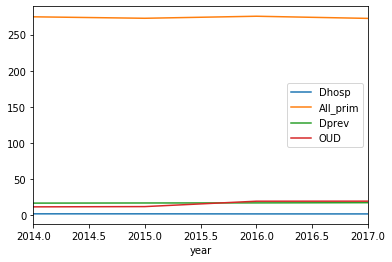

In [32]:
dhosp_year_avg_df = df3.groupby(['fips'])['Dhosp','All_prim','Dprev', 'OUD'].mean()
dhosp_year_avg_df.plot()
plt.show()


In [17]:
from scipy.stats import linregress 

dprev_pvtable.fillna(0, inplace=True)

a = [2014, 2015, 2016, 2017]

b = dprev_pvtable.iloc[0, :].values
linregress(a, b)


LinregressResult(slope=1.45, intercept=-2918.85, rvalue=0.25819888974716115, pvalue=0.7418011102528389, stderr=3.8363394010436567)

In [40]:
# find and count sparse columns
percent_missing = Xpred18_19.isnull().sum() * 100 / len(chr_df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})        

keep_columns = missing_value_df[missing_value_df.percent_missing <= 10].index

print(len(missing_value_df[percent_missing > 5]))
missing_value_df

#Ypred18_19 = model.predict(Xpred18_19)
#Ypred18_19

2


,percent_missing
fips,0.000000
year,0.000000
% 65 and older,0.000000
% American Indian and Alaskan Native,0.000000
% Asian,0.000000
% Females,0.000000
% Hispanic,0.000000
% Native Hawaiian/Other Pacific Islander,0.000000
% Non-Hispanic African American,0.000000
% Non-Hispanic white,0.000000


In [1]:

# from sklearn import ensemble
# from sklearn import linear_model

# params = {
#     'n_estimators': 1,
#     'max_depth': 1,
#     'learning_rate': 1,
#     'criterion': 'mse'
# }

# gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)

# gradient_boosting_regressor.fit(Xtrain, Ytrain)

